In [1]:
import os
import datetime
from functools import partial

import jax
import jax.numpy as jnp
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import numpy as np
import haiku as hk
import optax
import imageio
import skimage
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm, trange

import kompressor as kom

### Select the number of resolutions to train the model over

In [2]:
levels = 1

### Select neighbourhood size for prediction model

In [3]:
padding = 4

# At padding=0 use neighbours [A-D] to predict values [0-4]

# AB    A2B
# CD    041
#       C3D

# At padding=1 use neighbours [A-P] to predict values [0-4]

# ABCD    A.B.C.D
# EFGH    .......
# IJKL    E.F2G.H
# MNOP    ..041..
#         I.J3K.L
#         .......
#         M.N.O.P

### Define a simple prediction model based on an MLP

In [4]:
def MLPEncoder(padding, convolutional=False):

    def net_fn(lowres):

        # Extract data dimensions
        P, C = 5, 3

        # Fix kernel size to 1x1 to lock receptive field from growing
        K = 1
        
        # Standard LeNet-300-100 MLP network, parallelized over 2D feature maps

        # Extract the features for each neighborhood
        if convolutional:
            # Extract features from the raw RGB image batch using an even width kernel convolution
            features = jax.nn.relu(hk.Conv2D(300, ((padding + 1) * 2), padding='VALID')(lowres))
            H, W = features.shape[1:3]
        else:
            # Extract features from the raw RGB image batch using slicing and stacking followed by a 1x1 kernel convolution
            features = kom.image.features_from_lowres(lowres, padding)
            H, W = features.shape[1:3]
            features = jax.nn.relu(hk.Conv2D(300, K)(hk.Reshape((H, W, -1))(features)))

        # features.shape == (B, H, W, N*C)
        # where N = ((padding * 2) + 1) ^ 2 is the number of surrounding neighbours included for this padding value

        mlp = hk.Sequential([
            # Apply the rest of the network as 1x1 kernel convolutions
            hk.Conv2D(100, K), jax.nn.relu,
            
            # Output predictions for each neighbourhood
            hk.Conv2D((P*C), K),
            hk.Reshape((H, W, P, C)),
            # reshape (B, H, W, P*C) -> (B, H, W, P, C)
            # where P = 5, the number of values that need to be predicted for each neighbourhood
        ])

        # features(B, H, W, N, C) -> predictions(B, H, W, P, C)
        return mlp(features)

    return net_fn

In [5]:
def ConvolutionalEncoder(padding):

    def net_fn(lowres):

        # Extract data dimensions
        P, C = 5, 3

        # Extract features from the raw RGB image batch using an even width kernel convolution
        features = jax.nn.swish(hk.Conv2D(300, 2, padding='VALID')(lowres))
        
        for _ in range(padding):
            # Widen the receptive field up to the padding value using 3x3 convolutions to pool by [-1, +1) pixels with each layer
            features = jax.nn.swish(hk.Conv2D(100, 3, padding='VALID')(features))
            
        # Output predictions for each neighbourhood
        features = hk.Conv2D((P*C), 1)(features)
        H, W = features.shape[1:3]
        return hk.Reshape((H, W, P, C))(features)

    return net_fn

### Get a kompressor predictor function for a given network and parameter set that can be passed to encode/decode

In [6]:
def RegressionPredictor(model, params):

    # Regression predictor function applies convolutional MLP network
    @jax.jit
    def predictions_fn(lowres):
        # lowres.shape == (B, H, W, C)

        # Get predictions for neighbourhoods, first layer of network is a convolutional feature extractor
        predictions = model.apply(params, jnp.float32(lowres) / 256.)
        # Convert predictions to uint8
        predictions = jnp.floor(jnp.clip(predictions, 0, 1) * 256.).astype(lowres.dtype)
        # predictions.shape == (B, H, W, P, C)
        # where P = 5, the number of values that need to be predicted for each neighbourhood

        # Extract the maps from the predictions
        maps = kom.image.maps_from_predictions(predictions)
        # lrmap, udmap, cmap = maps
        return maps

    return predictions_fn

### Prototype of base-kompressor class for handling holding a model and applying it to multiple resolutions

In [7]:
class Kompressor:
    
    def __init__(self, encode_fn, decode_fn, padding):
        self.encode_fn, self.decode_fn = encode_fn, decode_fn
        self.padding = padding
        
    def _predictions_fn(self):
        raise NotImplementedError()
        
    def encode(self, highres, levels=1, chunk=None, progress_fn=None, debug=False):
        
        assert levels > 0
        
        predictions_fn = self._predictions_fn()
        
        maps = list()
        for level in range(levels):
            
            if chunk is None:
                lowres, maps_dims = kom.image.encode(predictions_fn, self.encode_fn, highres, padding=self.padding)
            else:
                lowres, maps_dims = kom.image.encode_chunks(predictions_fn, self.encode_fn, highres, padding=self.padding, chunk=chunk, progress_fn=progress_fn)
                
            if debug:
                maps.append((lowres, maps_dims, highres))
            else:
                maps.append(maps_dims)
                
            highres = lowres
            
        return lowres, maps

    def decode(self, lowres, maps, chunk=None, progress_fn=None, debug=False):
        
        assert len(maps) > 0
        
        predictions_fn = self._predictions_fn()
        
        for maps_dims in reversed(maps):
            
            if debug:
                _, maps_dims, _ = maps_dims
            
            if chunk is None:
                highres = kom.image.decode(predictions_fn, self.decode_fn, lowres, maps_dims, padding=self.padding)
            else:
                highres = kom.image.decode_chunks(predictions_fn, self.decode_fn, lowres, maps_dims, padding=self.padding, chunk=chunk, progress_fn=progress_fn)
            
            lowres = highres

        return highres                    

### Prototype of a Haiku based kompressor

In [8]:
class HaikuKompressor(Kompressor):
    
    def __init__(self, encode_fn, decode_fn, padding, model_fn, predictions_fn, seed=None):
        super().__init__(encode_fn=encode_fn, decode_fn=decode_fn, padding=padding)
        self.model_fn = model_fn
        self.__predictions_fn = predictions_fn
        self.params = self.avg_params = None
        
        self.model = hk.without_apply_rng(hk.transform(model_fn(self.padding)))
        
    def _predictions_fn(self):
        return self.__predictions_fn(self.model, self.avg_params)
    
    def init(self, ds_train, seed=None):
        
        ds_train = ds_train.as_numpy_iterator()
        
        if self.params is None:
            self.params = self.avg_params = self.model.init(jax.random.PRNGKey(seed or np.random.randint(1e6)), next(ds_train)['lowres'])
    
        return self
    
    def fit(self, ds_train, start_step=0, end_step=1, callbacks=None):
        
        callbacks = callbacks or list()
        
        assert 0 <= start_step < end_step
        
        ds_train = ds_train.as_numpy_iterator()
        
        opt = optax.adam(1e-5)
        opt_state = opt.init(self.params)
        
        @jax.jit
        def l2(params):
            return 0.5 * sum(jnp.sum(jnp.square(param)) for param in jax.tree_leaves(params))

        @jax.jit
        def loss(params, batch):
            predictions = self.model.apply(params, batch['lowres'])
            prediction_loss = jnp.mean(optax.l2_loss(predictions, batch['targets']))
            return prediction_loss + (1e-6 * l2(params))

        @jax.jit
        def update(params, opt_state, batch):
            value, grads = jax.value_and_grad(loss)(params, batch)
            updates, opt_state = opt.update(grads, opt_state)
            new_params = optax.apply_updates(params, updates)
            return value, new_params, opt_state

        @jax.jit
        def ema_update(params, avg_params):
            return optax.incremental_update(params, avg_params, step_size=0.001)
        
        # Train/eval loop
        for step in trange(start_step, end_step, desc='steps'):
            
            train_batch = next(ds_train)
            
            for callback in callbacks:
                callback.on_step_start(step=step, compressor=self)
            
            # Update params
            loss, self.params, opt_state = update(self.params, opt_state, train_batch)
            self.avg_params = ema_update(self.params, self.avg_params)

            for callback in callbacks:
                callback.on_step_end(step=step, loss=loss, compressor=self)
        
        # Return self to enable chaining
        return self

### Prototype of kompressor model training callbacks

In [9]:
class Callback:
    
    def on_step_start(self, *args, **kargs):
        pass
        
    
    def on_step_end(self, *args, **kargs):
        pass

In [10]:
class HaikuMetricsCallback(Callback):
    
    def __init__(self, log_dir, chunk, ds_train, ds_test=None, log_freq=100, levels=1):
        super().__init__()
        
        self.log_dir = log_dir
        
        assert log_freq > 0
        self.log_freq = log_freq
        
        assert levels > 0
        self.levels = levels
        
        self.chunk = chunk
        
        self.ds_train = ds_train.as_numpy_iterator()
        self.ds_test = None if ds_test is None else ds_test.as_numpy_iterator()
        
        self.writers = { mode: tf.summary.create_file_writer(os.path.join(self.log_dir, mode)) 
                         for mode in ['train', *([] if ds_test is None else ['test'])] }
        
    def on_step_end(self, step, loss, compressor, *args, **kargs):
        
        if not ((step == min(1, self.log_freq // 10)) or ((step >= self.log_freq) and (step % self.log_freq == 0))):
            return
        
        def log(highres, mode):
            
            lowres, level_encoded_maps = compressor.encode(highres, levels=self.levels, chunk=self.chunk, debug=True)
            
            for level, (level_highres, (level_encoded_maps, _), level_lowres) in enumerate(level_encoded_maps):
                
                level_highres_maps = kom.image.maps_from_highres(level_highres)
                shape = level_lowres.shape[1:]
                
                writer_path = os.path.join(self.log_dir, f'level {level}', f'shape {shape}', mode)
                if writer_path not in self.writers:
                    self.writers[writer_path] = tf.summary.create_file_writer(writer_path)       
            
                with self.writers[writer_path].as_default():
                    
                    for label, encoded_map, highres_map in zip(['lrmap', 'udmap', 'cmap'], level_encoded_maps, level_highres_maps):
                                                
                        centred_encoded_map = jnp.float32(kom.mapping.uint8.encode_transform_centre(encoded_map)) - 128.
                        
                        tf.summary.scalar(f'{label} | total variation', jnp.mean(kom.image.losses.mean_total_variation(centred_encoded_map)), step=step)
                        tf.summary.scalar(f'{label} | run length', jnp.mean(kom.image.metrics.mean_run_length(encoded_map)), step=step)
                        
                        for k in [1, 8]:
                            tf.summary.scalar(f'{label} | within k={k}', jnp.mean(kom.image.metrics.mean_within_k(centred_encoded_map, k)), step=step)

                        highres_bpp = kom.image.metrics.imageio_rgb_bpp(highres_map, format='png')
                        encoded_bpp = kom.image.metrics.imageio_rgb_bpp(encoded_map, format='png')
                        tf.summary.scalar(f'{label} | png bpp', jnp.mean(encoded_bpp), step=step)
                        tf.summary.scalar(f'{label} | png ratio', (1. - jnp.mean(encoded_bpp / highres_bpp)), step=step)
                    
        @jax.jit
        def l2(params):
            return 0.5 * sum(jnp.sum(jnp.square(param)) for param in jax.tree_leaves(params))
                    
        with self.writers['train'].as_default(): 
            tf.summary.scalar('loss', loss, step=step)
            tf.summary.scalar('l2', l2(compressor.params), step=step)
        log(next(self.ds_train), 'train')
        
        if self.ds_test is not None:            
            with self.writers['test'].as_default(): 
                tf.summary.scalar('l2', l2(compressor.avg_params), step=step)
            log(next(self.ds_test), 'test')
        

### Plot the encoded maps for a single level of compression

In [11]:
def plot_maps(title, highres, lowres, maps):

    ks = [1, 8, 64]
    
    fig, ax = plt.subplots(4, 7 + (3 * len(ks)), figsize=(36, 10), facecolor='w')

    plt.suptitle(title)

    plt.sca(ax[0, 0])
    plt.title(f'highres {highres[0].shape}')
    plt.axis('off')
    plt.axis('equal')
    plt.imshow(highres[0])

    plt.sca(ax[1, 0])
    plt.title(f'lowres {lowres[0].shape}')
    plt.axis('off')
    plt.axis('equal')
    plt.imshow(lowres[0])

    plt.sca(ax[2, 0])
    plt.axis('off')

    plt.sca(ax[3, 0])
    plt.axis('off')
    
    bins = np.arange(257)
    for midx, (label, m) in enumerate(zip(['lrmap', 'udmap', 'cmap'], maps)):

        im = kom.mapping.uint8.encode_transform_interleaved(m)
        cm = jnp.int32(kom.mapping.uint8.encode_transform_centre(m)) - 128
        
        plt.sca(ax[0, (midx*(2+len(ks)))+1])
        plt.title(f'{label} {m[0].shape}')
        #sns.despine(ax=plt.gca())
        for cidx, colour in reversed(list(enumerate('rgb'))):
            plt.hist(np.array(m[0, ..., cidx]).flatten(), bins=bins, color=colour, alpha=0.25, histtype='step', density=True)
            
        plt.sca(ax[0, (midx*(2+len(ks)))+2])
        plt.title(f'{label} centre')
        #sns.despine(ax=plt.gca())
        for cidx, colour in reversed(list(enumerate('rgb'))):
            plt.hist(np.array(cm[0, ..., cidx]).flatten(), bins=bins-128, color=colour, alpha=0.25, histtype='step', density=True)
        
        plt.sca(ax[0, (midx*(2+len(ks)))+3])
        plt.title(f'{label} interleave')
        #sns.despine(ax=plt.gca())
        for cidx, colour in reversed(list(enumerate('rgb'))):
            plt.hist(np.array(im[0, ..., cidx]).flatten(), bins=bins, color=colour, alpha=0.25, histtype='step', density=True)
            
        for ki, k in list(enumerate(ks))[1:]:
            plt.sca(ax[0, (midx*(2+len(ks)))+3+ki])
            plt.axis('off')
        
        for cidx, cmap in enumerate(['Reds', 'Greens', 'Blues']):

            plt.sca(ax[cidx+1, (midx*(2+len(ks)))+1])
            plt.xticks([])
            plt.yticks([])
            plt.imshow(im[0, ..., cidx], vmin=0, vmax=256, cmap=cmap)
            
            if midx == 0:
                plt.ylabel(cmap)
                
            if cidx == 2:
                plt.xlabel(f'{label}\nDelta')
            
            plt.sca(ax[cidx+1, (midx*(2+len(ks)))+2])
            plt.xticks([])
            plt.yticks([])
            plt.imshow(m[0, ..., cidx], vmin=0, vmax=256, cmap='tab10')
            
            if cidx == 2:
                plt.xlabel(f'{label}\nFalse Colour')
                
            for ki, k in enumerate(ks):
                plt.sca(ax[cidx+1, (midx*(2+len(ks)))+3+ki])
                plt.xticks([])
                plt.yticks([])
                plt.imshow(im[0, ..., cidx] < (k*2))

                plt.title(f'{(jnp.sum(im[0, ..., cidx] < (k*2)) / np.prod(im[0, ..., cidx].shape)) * 100:0.1f} %')
                
                if cidx == 2:
                    plt.xlabel(f'{label}\nWithin k={k}')

    plt.tight_layout()
    plt.show()

### Construct some dummy dataset pipelines using tensorflow.data

In [12]:
from glob import glob

In [13]:
ffhq_paths = sorted(list(glob('/home/pje39613/ffhq/data/thumbnails128x128/*/*/*.png')))

ffhq_split = int(len(ffhq_paths) * 0.8)

ffhq_train = ffhq_paths[:ffhq_split]
ffhq_test  = ffhq_paths[ffhq_split:]

print('ffhq_train', len(ffhq_train), 'ffhq_test', len(ffhq_test))

ffhq_train 56000 ffhq_test 14000


In [14]:
def decode_png_fn(path):
    return tf.io.decode_png(tf.io.read_file(path))

ds_train = tf.data.Dataset.from_tensor_slices(ffhq_train) \
    .repeat() \
    .shuffle(len(ffhq_train), reshuffle_each_iteration=True) \
    .map(decode_png_fn, num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)
ds_train = kom.image.data.random_chunk_dataset(ds_train, padding=padding, chunk=65, chunks_per_sample=32, chunks_shuffle_buffer=512, levels=levels) \
    .batch(256) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

ds_eval_train = tf.data.Dataset.from_tensor_slices(ffhq_train) \
    .map(decode_png_fn, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

ds_eval_test = tf.data.Dataset.from_tensor_slices(ffhq_test) \
    .map(decode_png_fn, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

### Create a trainable kompressor instance

In [15]:
encode_fn = kom.mapping.uint8.encode_values
decode_fn = kom.mapping.uint8.decode_values

compressor = HaikuKompressor(encode_fn=encode_fn, decode_fn=decode_fn, padding=padding, 
                             model_fn=ConvolutionalEncoder, predictions_fn=RegressionPredictor).init(ds_train)

### Apply the untrained kompressor to the test data

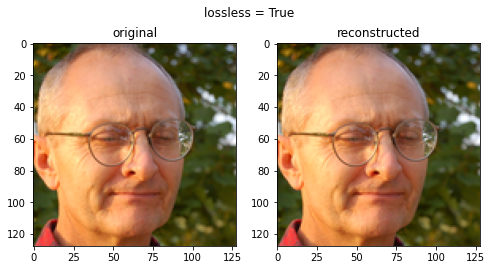

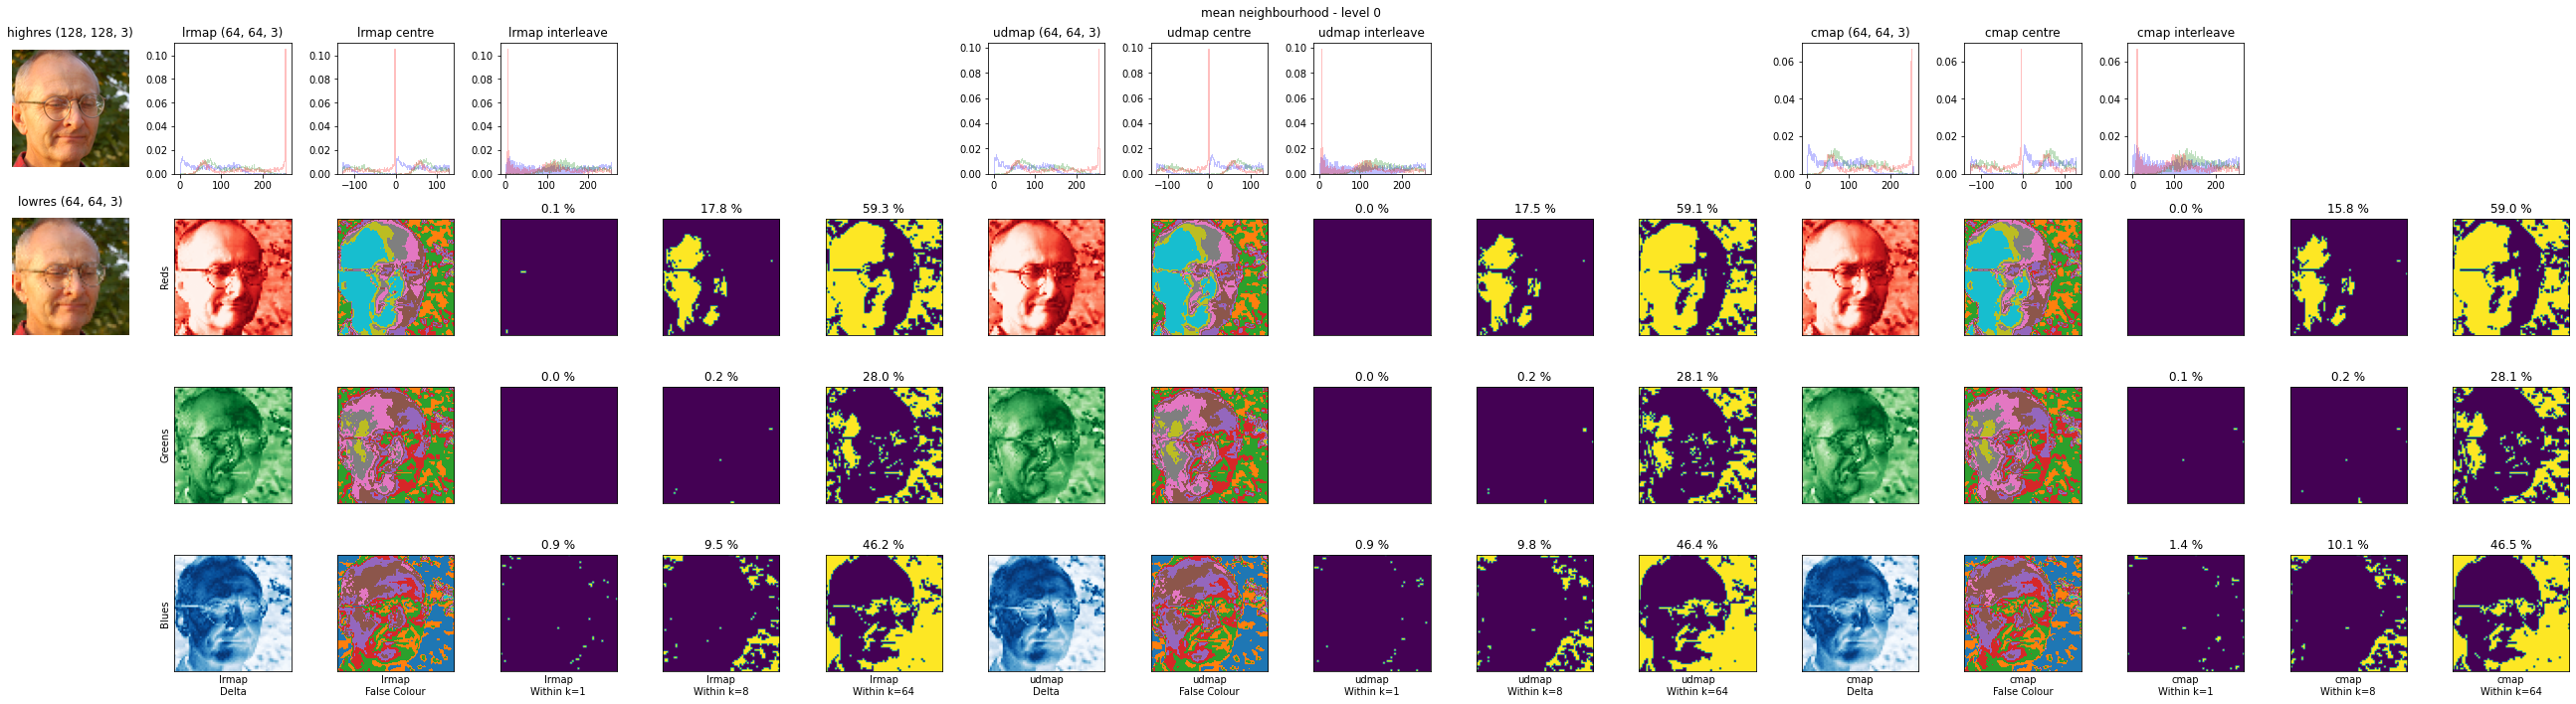

In [16]:
original_highres = jnp.array(next(iter(ds_eval_test))[:1])

encoded_lowres, encoded_maps = compressor.encode(original_highres, levels=levels, debug=True)
reconstructed_highres        = compressor.decode(encoded_lowres, encoded_maps, debug=True)

fig, ax = plt.subplots(1, 2, figsize=(8,4), facecolor='w')

plt.suptitle(f'lossless = {np.allclose(original_highres[0], reconstructed_highres[0])}')

plt.sca(ax[0])
plt.title('original')
plt.imshow(original_highres[0])

plt.sca(ax[1])
plt.title('reconstructed')
plt.imshow(reconstructed_highres[0])

plt.show()

for level, (lowres, (maps, dims), highres) in enumerate(encoded_maps):
    plot_maps(f'mean neighbourhood - level {level}', highres, lowres, maps)

### Train the kompressor instance

In [17]:
callbacks = [
    HaikuMetricsCallback(log_dir=os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), 
                         chunk=256, ds_train=ds_eval_train, ds_test=ds_eval_test, log_freq=1000, levels=1)
]

compressor.fit(ds_train=ds_train, start_step=0, end_step=100001, callbacks=callbacks)

steps: 100%|██████████████████████████████████████████████████████████| 100001/100001 [1:06:50<00:00, 24.93it/s]


### Apply the trained kompressor to the test data

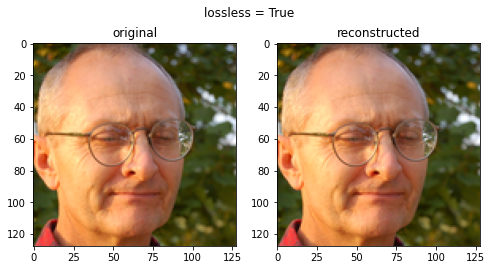

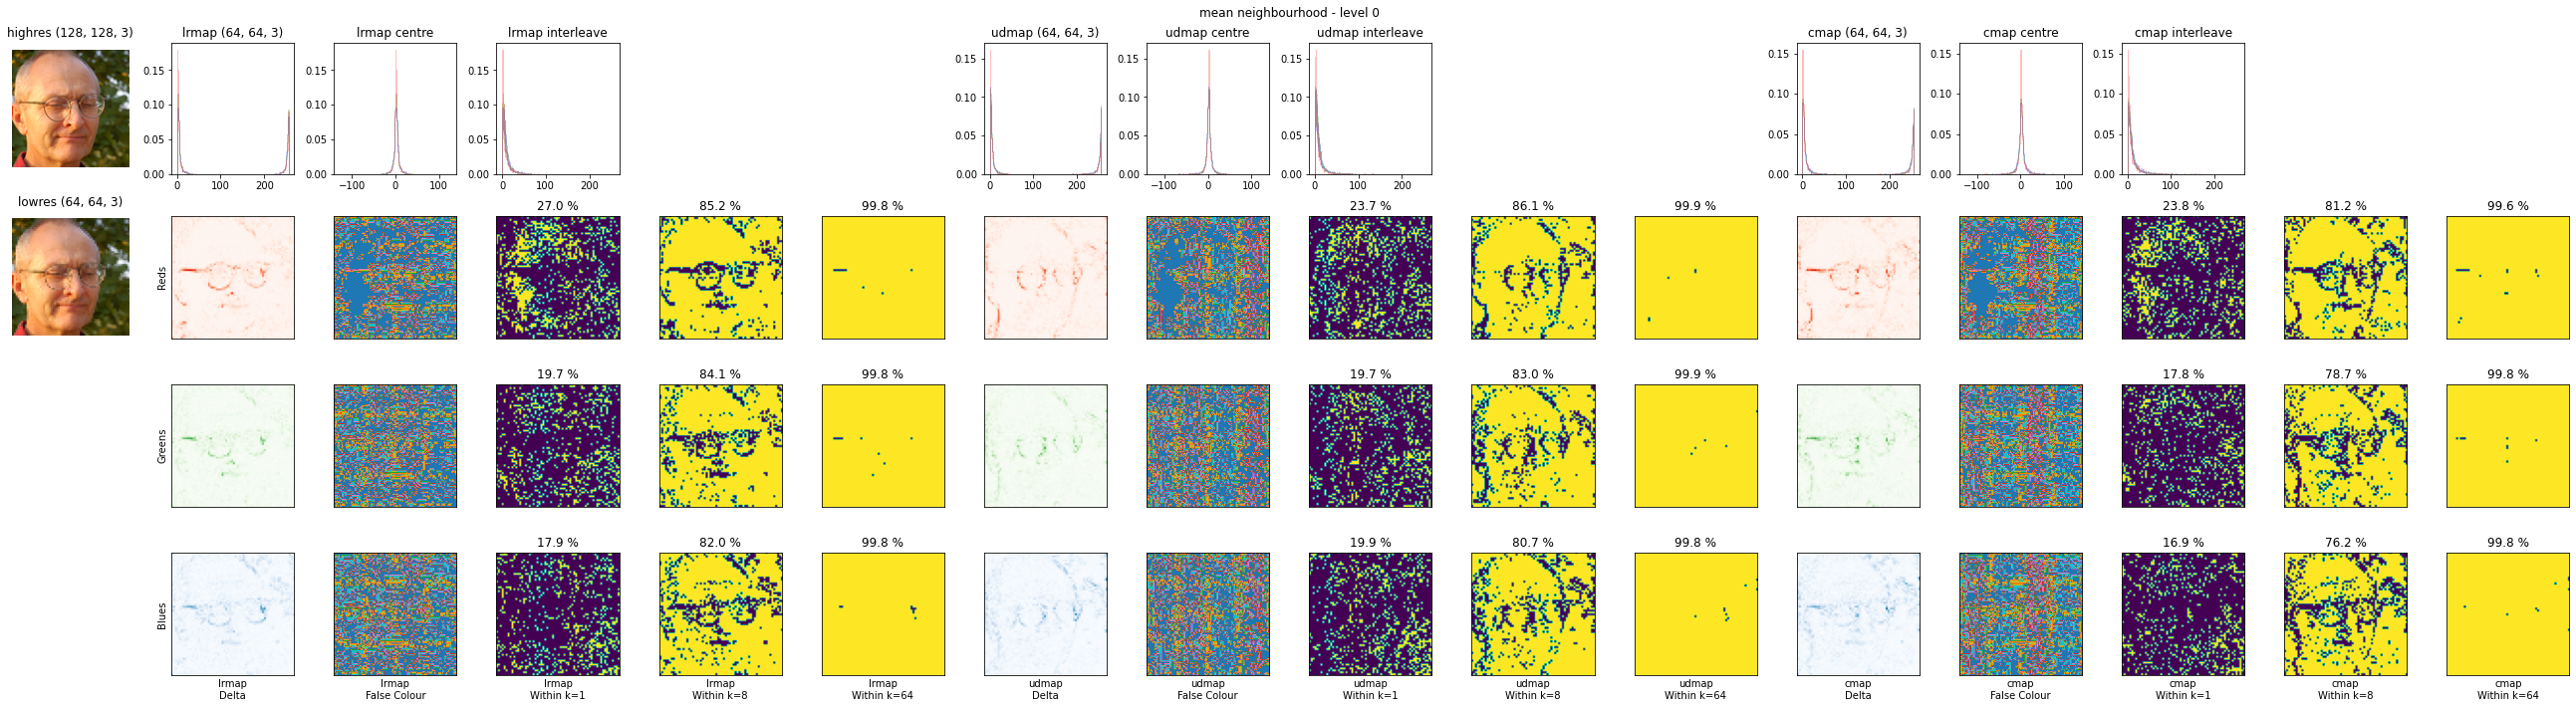

In [18]:
encoded_lowres, encoded_maps = compressor.encode(original_highres, levels=levels, debug=True)
reconstructed_highres        = compressor.decode(encoded_lowres, encoded_maps, debug=True)

fig, ax = plt.subplots(1, 2, figsize=(8,4), facecolor='w')

plt.suptitle(f'lossless = {np.allclose(original_highres[0], reconstructed_highres[0])}')

plt.sca(ax[0])
plt.title('original')
plt.imshow(original_highres[0])

plt.sca(ax[1])
plt.title('reconstructed')
plt.imshow(reconstructed_highres[0])

plt.show()

for level, (lowres, (maps, dims), highres) in enumerate(encoded_maps):
    plot_maps(f'mean neighbourhood - level {level}', highres, lowres, maps)